# Model Evaluation

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')
import joblib

# Modelleri yükleme
model_lgb = joblib.load('/kaggle/input/lgb/other/default/1/lgb_optimized_pubg.pkl')
model_xgb = joblib.load('/kaggle/input/xgb/other/default/1/xgb_optimized_pubg.pkl')

print("Modeller yüklendi")

Modeller yüklendi


* Modelleri ve gerekli kütüphaneleri yükledik
* LightGBM ve XGBoost modellerini dosyadan yükleyip kullanıma hazır hale getirdim.

In [ ]:
train = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
train = train.dropna(subset=['winPlacePerc'])

# Özellik ayarlama
train['totalDistance'] = train['walkDistance'] + train['rideDistance'] + train['swimDistance']
train['walkRideRatio'] = train['walkDistance'] / (train['rideDistance'] + 1)
train['damagePerKill'] = train['damageDealt'] / (train['kills'] + 1)

train['playersInGroup'] = train.groupby('groupId')['Id'].transform('count')
train['playersInMatch'] = train.groupby('matchId')['Id'].transform('count')

train['combatScore'] = train['kills'] * 0.7 + train['damageDealt'] * 0.3
train['playerAggression'] = (
    train['walkDistance'] * 0.5 +
    train['kills'] * 1.5 +
    train['damageDealt'] * 0.3
)

y = train['winPlacePerc']

features = [
    'kills', 'damageDealt', 'walkDistance', 'rideDistance', 'weaponsAcquired',
    'totalDistance', 'walkRideRatio', 'damagePerKill', 'playersInGroup',
    'playersInMatch', 'combatScore', 'playerAggression'
]

train['matchType'] = train['matchType'].astype('category')
features_cat = ['matchType']

for col in features_cat:
    train[col] = train[col].cat.codes

X = train[features + features_cat]

*  PUBG veri setini yükledim ve eksik winPlacePerc değerlerini çıkardım. 
*  Ardından model için yeni özellikler oluşturdum ve kategorik `matchType` değişkenini sayısal kodlara çevirdim.
*  Feature matrix `X` ve hedef değişken `y` hazır.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

Train shape: (3557572, 13), Validation shape: (889393, 13)


*  Veri setini %80 eğitim ve %20 doğrulama olacak şekilde ayırdım. 
*  Böylece modelleri eğitirken ve doğrularken performans karşılaştırması yapabileceğiz.

In [11]:
# LightGBM tahmin ve RMSE
preds_val_lgb = model_lgb.predict(X_val)
rmse_val_lgb = np.sqrt(mean_squared_error(y_val, preds_val_lgb))
print(f"LightGBM Validation RMSE: {rmse_val_lgb:.4f}")

# XGBoost tahmin ve RMSE
preds_val_xgb = model_xgb.predict(X_val)
rmse_val_xgb = np.sqrt(mean_squared_error(y_val, preds_val_xgb))
print(f"XGBoost Validation RMSE: {rmse_val_xgb:.4f}")

LightGBM Validation RMSE: 0.1499
XGBoost Validation RMSE: 0.1658


*  LightGBM ve XGBoost modellerini doğrulama seti üzerinde tahmin ettim ve RMSE hesapladım. 
*  LightGBM RMSE: 0.1499 → Daha düşük hata ile daha iyi performans gösteriyor.

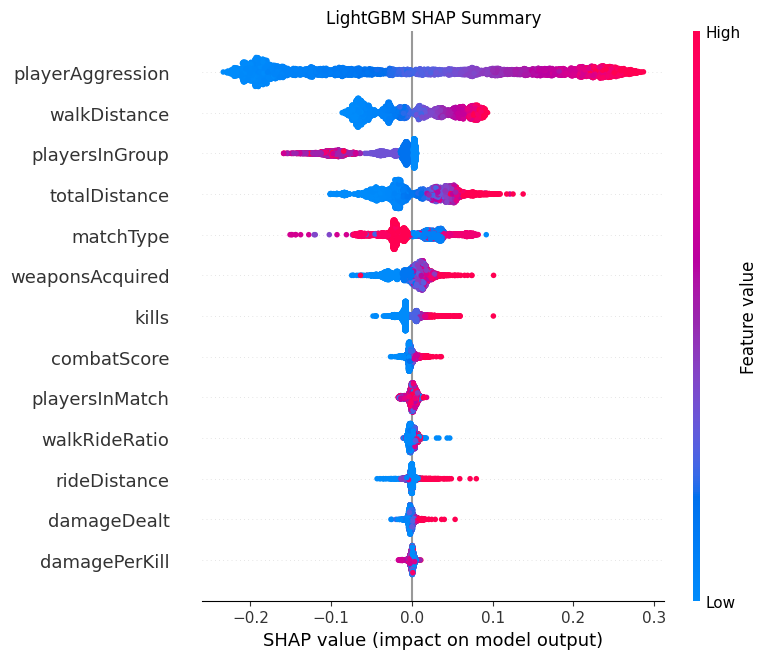

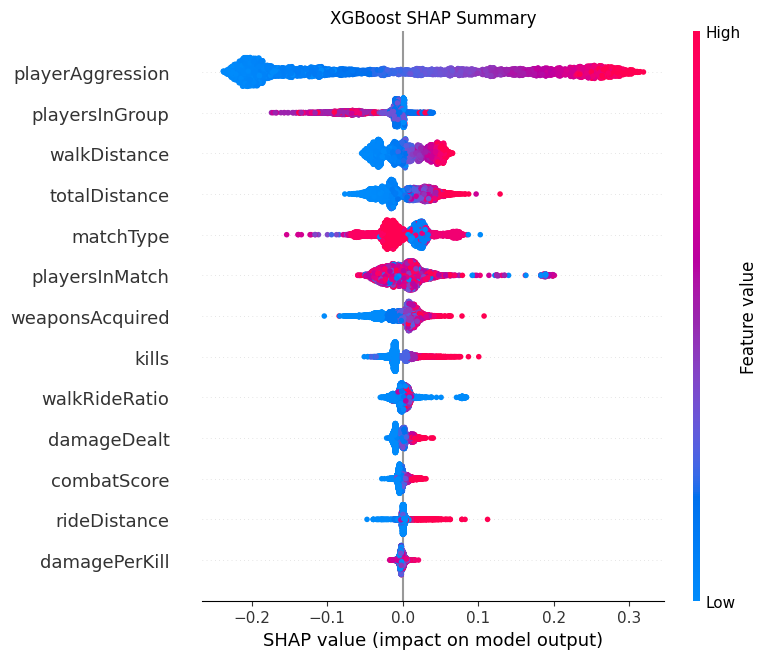

In [13]:
# LightGBM SHAP
explainer_lgb = shap.TreeExplainer(model_lgb)
sample_size = min(5000, len(X_val))
X_val_sample = X_val.sample(sample_size, random_state=42)

shap_values_lgb = explainer_lgb.shap_values(X_val_sample)
if isinstance(shap_values_lgb, list):
    shap_values_lgb = shap_values_lgb[0]

plt.title("LightGBM SHAP Summary")
shap.summary_plot(shap_values_lgb, X_val_sample, max_display=15, show=True)

# XGBoost SHAP
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_val_sample)
if isinstance(shap_values_xgb, list):
    shap_values_xgb = shap_values_xgb[0]

plt.title("XGBoost SHAP Summary")
shap.summary_plot(shap_values_xgb, X_val_sample, max_display=15, show=True)

Yukarıdaki grafikler, LightGBM ve XGBoost modellerinin özniteliklerin hedef değişkene etkisini SHAP değerleri ile göstermektedir. 

- **Her iki modelde de `playerAggression`, `walkDistance` ve `playersInGroup` gibi özellikler en yüksek etkiye sahip** görünüyor. Bu, oyuncu agresyonu ve hareket mesafesinin PUBG bitiş yerini tahminlemede kritik olduğunu gösterir.
- SHAP değerlerinin dağılımı, yüksek özellik değerlerinin (kırmızı noktalar) pozitif veya negatif model çıktısına etkisini net bir şekilde ortaya koyuyor.
- LightGBM modelinde `walkDistance` ve `playersInGroup` etkisi biraz daha belirginken, XGBoost modelinde bazı özelliklerin etkisi göreceli olarak daha az değişkenlik gösteriyor.
- Genel olarak, her iki model de benzer özniteliklere odaklanıyor ancak etki büyüklükleri ve dağılımları farklılık gösteriyor.

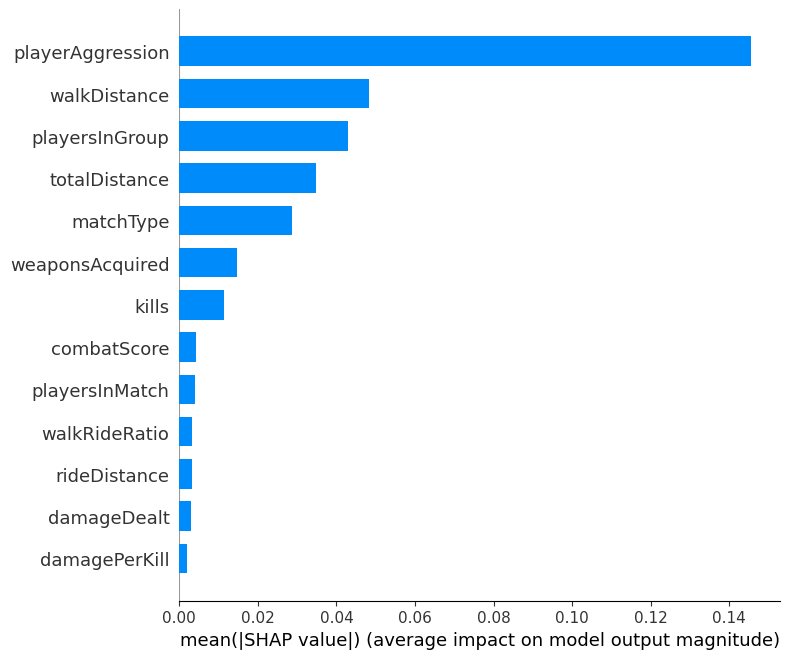

In [14]:
shap.summary_plot(shap_values, X_val_sample, plot_type='bar', max_display=15)

Bu grafik, modeldeki özniteliklerin göreceli önemini SHAP değerlerinin ortalama mutlak büyüklüklerine göre sıralar. 

- En önemli 15 özellik görselleştirilmiştir.
- Özelliklerin modele etkisinin büyüklüğü ve göreceli önemi açıkça görülür.
- `playerAggression`, `walkDistance` ve `playersInGroup` gibi temel özellikler en yüksek ortalama SHAP değerlerine sahip olarak modelde en etkili öznitelikler olarak öne çıkıyor.